# Reinforcement learning (https://farama.org/Announcing-The-Farama-Foundation)
Reinforcement learning is conceptualized as a loop where an agent interacts with its environment in discrete time steps. At each step, the agent observes the current state, selects and executes an action, and in response, the environment transitions to a new state and returns a reward. This cycle repeats, forming a feedback loop.

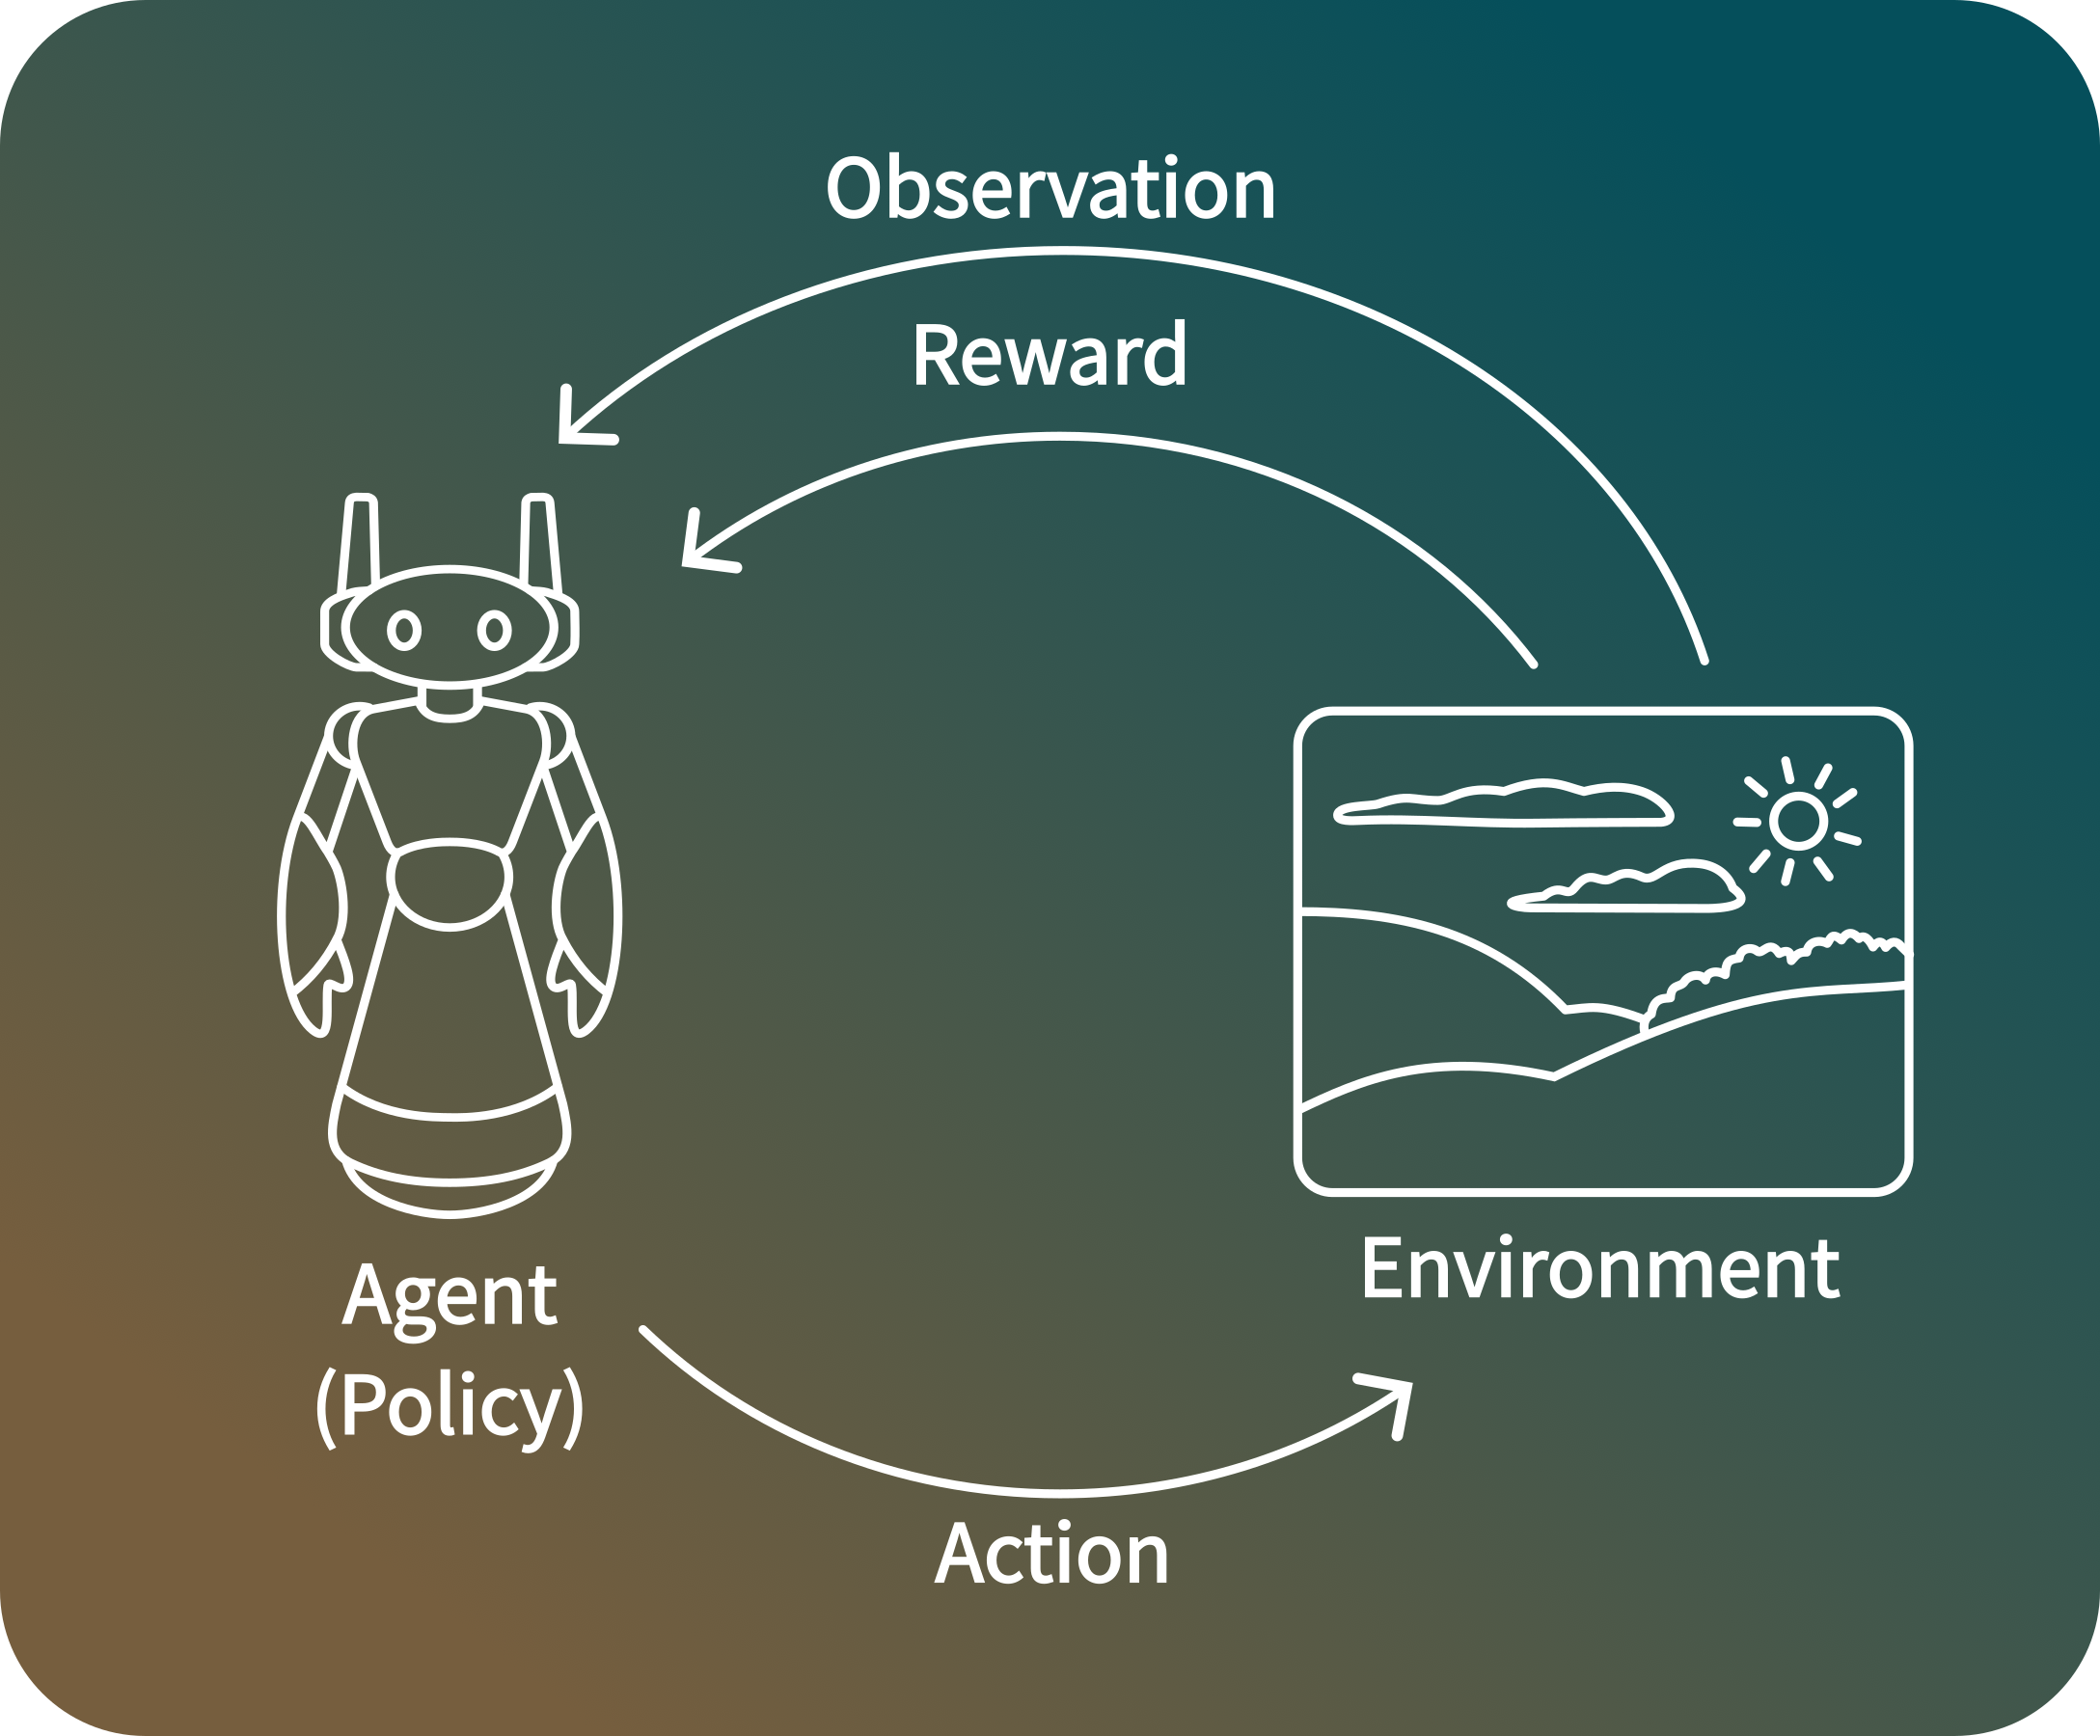

In supervised learning, the software stack is simple—just a dataset, preprocessing, and a deep learning library. In contrast, reinforcement learning (RL) involves a more complex stack: it starts with building an interactive environment (e.g., simulation or game), wrapping it with a standard API, applying preprocessing wrappers if needed, and finally using RL algorithms implemented with deep learning tools like PyTorch or TensorFlow.

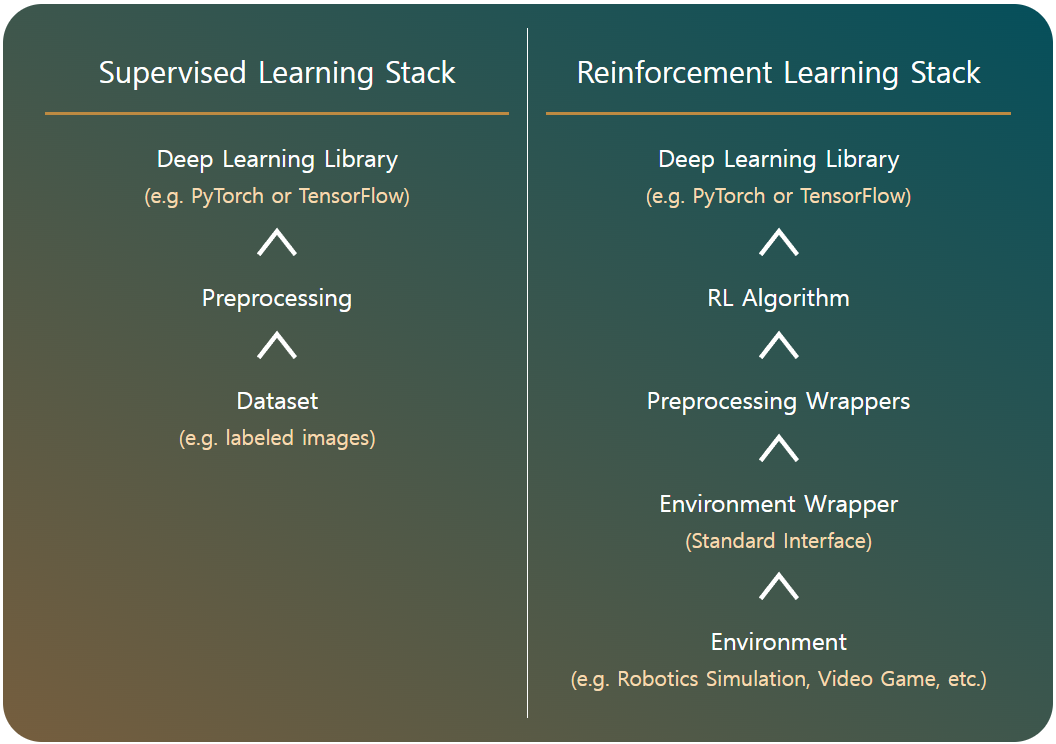

In [2]:
%%capture
#remove " > /dev/null 2>&1" to see what is going on under the hood
!apt-get update > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1

!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1

!pip install swig==4.1.1
!pip install Box2D==2.3.2
!pip install box2d-kengz==2.3.3
!pip install pygame==2.2.0
!pip install ale_py==0.8.1
!pip install pyglet==1.5.11

!pip install -U colabgymrender
!pip install imageio==2.4.1
!pip install --upgrade AutoROM
!AutoROM --accept-license
!pip install gymnasium[atari]==0.28.1

!wget http://www.atarimania.com/roms/Roms.rar
!unrar x -o+ /content/Roms.rar >/dev/nul
!python -m atari_py.import_roms /content/ROMS >/dev/nul

!pip install pyvirtualdisplay > /dev/null 2>&1

!pip install --upgrade gym

In [3]:
# import mujoco
import gymnasium as gym
import numpy as np
import glob
import matplotlib.pyplot as plt
%matplotlib inline

# List of Environment

- `gym` (or `gymnasium`) is a standard library for developing and comparing reinforcement learning (RL) algorithms.

- It serves as a standardized API for RL environments, ensuring long-term maintenance and improvements in reproducibility and performance.

- It provides a wide range of benchmark environments (e.g., classic control, Atari, robotics) with a consistent interface, making it easy to test RL agents.

- The code below shows how to list all available environments registered in the gym library, which is helpful when choosing an environment to train/test an agent.

In [4]:
# List all environments registered in gymnasium
env_specs = gym.envs.registry

# Traverse and print all environment IDs
for env_spec in env_specs:
    print(env_spec)

CartPole-v0
CartPole-v1
MountainCar-v0
MountainCarContinuous-v0
Pendulum-v1
Acrobot-v1
CartPoleJax-v0
CartPoleJax-v1
PendulumJax-v0
LunarLander-v2
LunarLanderContinuous-v2
BipedalWalker-v3
BipedalWalkerHardcore-v3
CarRacing-v2
Blackjack-v1
FrozenLake-v1
FrozenLake8x8-v1
CliffWalking-v0
Taxi-v3
Jax-Blackjack-v0
Reacher-v2
Reacher-v4
Pusher-v2
Pusher-v4
InvertedPendulum-v2
InvertedPendulum-v4
InvertedDoublePendulum-v2
InvertedDoublePendulum-v4
HalfCheetah-v2
HalfCheetah-v3
HalfCheetah-v4
Hopper-v2
Hopper-v3
Hopper-v4
Swimmer-v2
Swimmer-v3
Swimmer-v4
Walker2d-v2
Walker2d-v3
Walker2d-v4
Ant-v2
Ant-v3
Ant-v4
Humanoid-v2
Humanoid-v3
Humanoid-v4
HumanoidStandup-v2
HumanoidStandup-v4
GymV26Environment-v0
GymV21Environment-v0
Adventure-v0
AdventureDeterministic-v0
AdventureNoFrameskip-v0
Adventure-v4
AdventureDeterministic-v4
AdventureNoFrameskip-v4
Adventure-ram-v0
Adventure-ramDeterministic-v0
Adventure-ramNoFrameskip-v0
Adventure-ram-v4
Adventure-ramDeterministic-v4
Adventure-ramNoFrameskip-

# Discrete MDP
### FrozenLake
 - `gym.make()` is a function from OpenAI’s gym library used to create or instantiate an environment.
 - `env.reset()`: This function resets the environment to its initial state. It is usually done at the start of an episode or when an episode ends. It returns the initial observation (state) of the environment, although in this code the return value isn’t being stored.
 - `env.render()`: Display a visual frame in a window (useful for real-time monitoring of what an agent is doing).
Return a numerical representation of the visual frame.

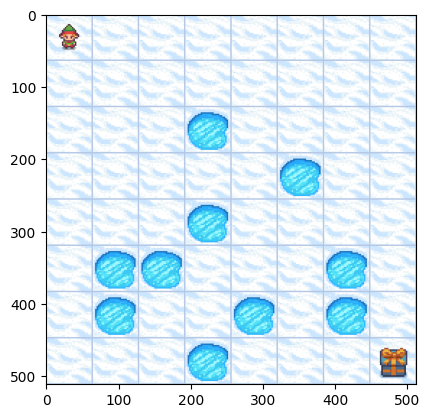

In [5]:
env = gym.make('FrozenLake8x8-v1', render_mode="rgb_array")
env.reset()
plt.imshow(env.render())

### FrozenLake: Observation & Action Space
- `env.observation_space`: Represents the observation (state) space of the environment. It is of type Discrete(n), meaning there are n possible discrete states.

- `env.action_space`: Represents the action space of the environment. Also of type Discrete(n), indicating there are n possible discrete actions.

You can use .n to get the total number of states or actions.

In [6]:
obs_space = env.observation_space
print('Observation space')
print(type(obs_space))
print("Total {} states".format(obs_space.n))
print()

act_space = env.action_space
print('Action space')
print(type(act_space))
print("Total {} actions".format(act_space.n))
print()

Observation space
<class 'gymnasium.spaces.discrete.Discrete'>
Total 64 states

Action space
<class 'gymnasium.spaces.discrete.Discrete'>
Total 4 actions



### Visualization of An Episode

Sampling and Taking a Step in the Environment
- `action = env.action_space.sample()`:
Randomly samples an action from the environment’s action space. This is typically used for exploration or as a baseline behavior.

- `obs, reward, done, _, info = env.step(action)`:
Applies the chosen action to the environment:

  - `obs`: the next observation (state)

  - `reward`: the immediate reward received for the action

  - `done`: a boolean flag indicating whether the episode has ended

  - `_`: (unused) typically the truncated flag in Gymnasium

  - `info`: additional diagnostic information (may include metadata like time limits, success flags, etc.)

In [7]:
import cv2
from matplotlib import animation
from IPython.display import display, HTML

def display_animation(anim):
    plt.close(anim._fig)
    return HTML(anim.to_jshtml())
def display_frames_as_gif(frames):
    patch = plt.imshow(frames[0])
    plt.axis('off')
    def animate(i):
        patch.set_data(frames[i])
    anim = animation.FuncAnimation(
        plt.gcf(),animate,frames=len(frames),interval=100)
    display(display_animation(anim))

# Loop
env.reset()
frames = []
for t in range(50):
    frame = env.render()
    texted_frame = cv2.putText(
        img=np.copy(frame),text='tick:%d'%(t),org=(100,100),
        fontFace=3,fontScale=2,color=(0,0,255),thickness=3)
    frames.append(texted_frame)
    action = env.action_space.sample() # random action
    obs, reward, done, _, info = env.step(action) # step
    if done: break
env.close()
print ("[%d] frames."%(len(frames)))
display_frames_as_gif(frames)

Output hidden; open in https://colab.research.google.com to view.

### FrozenLake: Transition Probability Dictionary
- `env.unwrapped.P`:
Accesses the underlying transition probability dictionary `P` of the environment (used in environments with a known MDP model, like FrozenLake). It defines the dynamics of the environment:

  `P[s][a]` is a list of transitions that can occur when taking action `a` in state `s`.

- Each element in `P[s][a]` is a tuple:
(probability, next_state, reward, done)

In [8]:
P = env.unwrapped.P
# P(s'|s,a)
print('State:')
print(type(P))
print(P.keys())
print()

print('Action:')
print(P[0].keys())
print(P[0][0])
print()

print('Prob, Next state, Reward, Done:')
print(P[0][0][0])

State:
<class 'dict'>
dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63])

Action:
dict_keys([0, 1, 2, 3])
[(0.3333333333333333, 0, 0.0, False), (0.3333333333333333, 0, 0.0, False), (0.3333333333333333, 8, 0.0, False)]

Prob, Next state, Reward, Done:
(0.3333333333333333, 0, 0.0, False)


In [9]:
for s in P.keys():
    for a in P[s].keys():
        for next_s_info in P[s][a]:
            print('P(s\':{}|s:{},a:{}) = {:.2}, Reward:{}'.format(next_s_info[1],s,a,next_s_info[0],next_s_info[2]))

P(s':0|s:0,a:0) = 0.33, Reward:0.0
P(s':0|s:0,a:0) = 0.33, Reward:0.0
P(s':8|s:0,a:0) = 0.33, Reward:0.0
P(s':0|s:0,a:1) = 0.33, Reward:0.0
P(s':8|s:0,a:1) = 0.33, Reward:0.0
P(s':1|s:0,a:1) = 0.33, Reward:0.0
P(s':8|s:0,a:2) = 0.33, Reward:0.0
P(s':1|s:0,a:2) = 0.33, Reward:0.0
P(s':0|s:0,a:2) = 0.33, Reward:0.0
P(s':1|s:0,a:3) = 0.33, Reward:0.0
P(s':0|s:0,a:3) = 0.33, Reward:0.0
P(s':0|s:0,a:3) = 0.33, Reward:0.0
P(s':1|s:1,a:0) = 0.33, Reward:0.0
P(s':0|s:1,a:0) = 0.33, Reward:0.0
P(s':9|s:1,a:0) = 0.33, Reward:0.0
P(s':0|s:1,a:1) = 0.33, Reward:0.0
P(s':9|s:1,a:1) = 0.33, Reward:0.0
P(s':2|s:1,a:1) = 0.33, Reward:0.0
P(s':9|s:1,a:2) = 0.33, Reward:0.0
P(s':2|s:1,a:2) = 0.33, Reward:0.0
P(s':1|s:1,a:2) = 0.33, Reward:0.0
P(s':2|s:1,a:3) = 0.33, Reward:0.0
P(s':1|s:1,a:3) = 0.33, Reward:0.0
P(s':0|s:1,a:3) = 0.33, Reward:0.0
P(s':2|s:2,a:0) = 0.33, Reward:0.0
P(s':1|s:2,a:0) = 0.33, Reward:0.0
P(s':10|s:2,a:0) = 0.33, Reward:0.0
P(s':1|s:2,a:1) = 0.33, Reward:0.0
P(s':10|s:2,a:1) = 

# Continuous MDP
### CartPole

In [10]:
env = gym.make('CartPole-v1', render_mode="rgb_array")
obs = env.reset()

### CartPole: Observation & Action Space
- `env.observation_space` is typically of type Box, representing a continuous multi-dimensional space.

- `.shape`: The shape (dimensions) of the observation vector.

- `.high` / `.low`: The upper and lower bounds of each observation dimension.

In [11]:
obs_space = env.observation_space
print('Observation space')
print(type(obs_space))
print(obs_space.shape)
print("Dimension:{}".format(obs_space.shape[0]))
print("High: {}".format(obs_space.high))
print("Low: {}".format(obs_space.low))
print()

act_space = env.action_space
print('Action space')
print(type(act_space))
print("Total {} actions".format(act_space.n))
print()

Observation space
<class 'gymnasium.spaces.box.Box'>
(4,)
Dimension:4
High: [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38]
Low: [-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38]

Action space
<class 'gymnasium.spaces.discrete.Discrete'>
Total 2 actions



### State Example

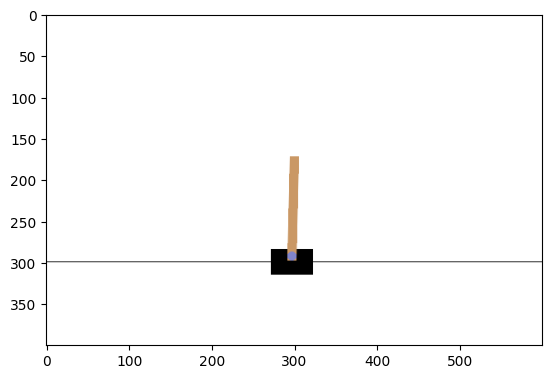

In [12]:
env.reset()
frame = env.render()
plt.imshow(frame)
env.close()

### Animation in Jupyter Notebook

In [17]:
env = gym.make('CartPole-v1', render_mode="rgb_array")
env.reset()
frames = []
for t in range(1000):
    frame = env.render()
    texted_frame = cv2.putText(
        img=np.copy(frame),text='tick:%d'%(t),org=(100,100),
        fontFace=3,fontScale=2,color=(0,0,255),thickness=3)
    frames.append(texted_frame)
    action = env.action_space.sample() # random action
    obs, reward, done, _, info = env.step(action) # step
    if done: break
env.close()
print ("[%d] frames."%(len(frames)))
display_frames_as_gif(frames)

[18] frames.


# Mountain Car

In [21]:
env = gym.make('MountainCarContinuous-v0', render_mode="rgb_array")
env.reset()
frames = []
for t in range(100):
    frame = env.render()
    texted_frame = cv2.putText(
        img=np.copy(frame),text='tick:%d'%(t),org=(100,100),
        fontFace=3,fontScale=2,color=(0,0,255),thickness=3)
    frames.append(texted_frame)
    action = env.action_space.sample() # random action
    obs, reward, done, _, info = env.step(action) # step
    if done: break
env.close()
print ("[%d] frames."%(len(frames)))
display_frames_as_gif(frames)

Output hidden; open in https://colab.research.google.com to view.

# Problem 1.

1. Create 'Breakout-v4' environment
2. Print the type, shape, high and low of observation space
3. Print the type, shape, high and low (or the number of actions) of action space
4. Reset environment and render an initial state
5. Run an episode with random policy and visualize it

In [22]:
env = gym.make('Breakout-v4', render_mode="rgb_array")
obs = env.reset()

In [23]:
obs_space = env.observation_space
print('Observation space')
print(type(obs_space))
print(obs_space.shape)
print("High: {}".format(obs_space.high))
print("Low: {}".format(obs_space.low))
print()

Observation space
<class 'gymnasium.spaces.box.Box'>
(210, 160, 3)
High: [[[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 ...

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]]
Low: [[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0

In [24]:
act_space = env.action_space
print('Action space')
print(type(act_space))
print("Total {} actions".format(act_space.n))
print()

Action space
<class 'gymnasium.spaces.discrete.Discrete'>
Total 4 actions



In [ ]:
act_space = env.action_space
print('Action space')
print(type(act_space))
print("Total {} actions".format(act_space.n))
print()

Action space
<class 'gymnasium.spaces.discrete.Discrete'>
Total 4 actions



/usr/local/lib/python3.11/dist-packages/gymnasium/utils/passive_env_checker.py:364: UserWarning: WARN: No render fps was declared in the environment (env.metadata['render_fps'] is None or not defined), rendering may occur at inconsistent fps.
  logger.warn(


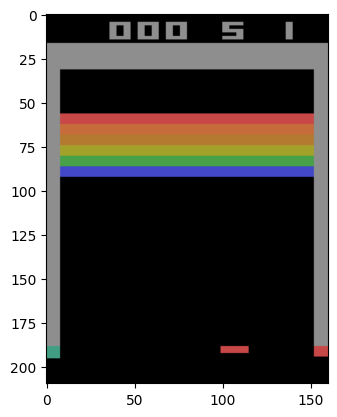

In [25]:
env.reset()
frame = env.render()
plt.imshow(frame)
env.close()

In [27]:
def display_animation(anim):
    plt.close(anim._fig)
    return HTML(anim.to_jshtml())
def display_frames_as_gif(frames):
    patch = plt.imshow(frames[0])
    plt.axis('off')
    def animate(i):
        patch.set_data(frames[i])
    anim = animation.FuncAnimation(
        plt.gcf(),animate,frames=len(frames),interval=100)
    display(display_animation(anim))

# Loop
env.reset()
frames = []
for t in range(1000):
    frame = env.render()
    texted_frame = cv2.putText(
        img=np.copy(frame),text='tick:%d'%(t),org=(100,100),
        fontFace=1,fontScale=1,color=(0,0,255),thickness=1)
    frames.append(texted_frame)
    action = env.action_space.sample() # random action
    obs, reward, done, _, info = env.step(action) # step

    if done: break
env.close()
print ("[%d] frames."%(len(frames)))
display_frames_as_gif(frames)

Output hidden; open in https://colab.research.google.com to view.